In [1]:
from helper_functions.preprocessing import preprocessor
from helper_functions.metrics import durbin_watson,mean_absolute_percentage_error, negative_mean_absolute_percentage_error

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from pandas.api.types import is_object_dtype
from sklearn.kernel_ridge import KernelRidge
import xgboost as xg 
from xgboost import plot_importance
import scipy.stats as stats

In [3]:
csv_data = pd.read_csv('immo_dev_data.csv')

In [4]:
csv_data

,Id,AreaLiving,AreaProperty,BuiltYear,FloorNumber,ForestDensityL,ForestDensityM,ForestDensityS,GroupNameDe,HouseObject,...,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,location_has_street,location_is_complete,PurchasePrice
0,7135329,140.0,501.0,2016,NaN,0.418964,0.555985,0.730714,Haus,True,...,1358.0,3.660512,8.73,17.0,162.0,358.0,537.0,0,0,745000.0
1,7170979,143.0,277.0,2004,NaN,0.033259,0.074061,0.076468,Haus,True,...,3476.0,3.634717,6.13,0.0,2250.0,2787.0,5041.0,1,1,780000.0
2,7172246,160.0,712.0,1945,NaN,0.000000,0.000000,0.000000,Haus,True,...,2806.0,2.512344,9.79,167.0,1694.0,1138.0,2999.0,0,0,570000.0
3,7172252,351.0,496.0,2016,NaN,0.037575,0.000000,0.000000,Haus,True,...,131.0,1.734104,9.15,12.0,10.0,17.0,39.0,0,0,920000.0
4,7172733,400.0,1800.0,1975,NaN,0.095162,0.097193,0.153314,Haus,True,...,1181.0,1.056052,2.97,0.0,27.0,701.0,732.0,0,0,3950000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153622,42175297,116.0,0.0,2005,NaN,0.002560,0.000000,0.000000,Attikawohnung,False,...,9207.0,9.211883,3.09,0.0,3838.0,20507.0,24347.0,0,0,1700000.0
153623,42175302,70.0,0.0,1978,NaN,0.019577,0.041224,0.001321,Wohnung,False,...,5511.0,6.205661,3.18,8.0,1328.0,4433.0,5769.0,0,0,720000.0
153624,42175305,136.0,0.0,1997,2.0,0.068206,0.058172,0.000000,Wohnung,False,...,178.0,0.000000,8.68,37.0,27.0,44.0,108.0,0,0,725000.0
153625,42175727,60.0,0.0,2009,NaN,0.098870,0.020076,0.000000,Wohnung,False,...,2700.0,0.872739,4.90,282.0,396.0,1589.0,2267.0,0,0,289000.0


In [5]:
csv_data_test = csv_data[['Zip', 'GroupNameDe', 'AreaLiving', 'PurchasePrice', 'location_has_street']]
csv_data_test['Zip'] = (csv_data_test['Zip']/100).astype('int8').copy()
prepro_test = preprocessor(csv_data_test, y_var='PurchasePrice', cols_to_drop=[], numbers_to_encode=['Zip'])#, 'Id'])
prepro_test.preprocess()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
Columns dropped to create X:  []
Succesfully casted Dtypes!
 Zip                     object
GroupNameDe             object
AreaLiving             float64
location_has_street      int64
dtype: object


In [6]:
prepro_test.X_train

,AreaLiving,location_has_street,Zip_10_,Zip_11_,Zip_12_,Zip_13_,Zip_14_,Zip_15_,Zip_16_,Zip_17_,...,GroupNameDe_Attikawohnung,GroupNameDe_Doppelhaus,GroupNameDe_Haus,GroupNameDe_Loftwohnung,GroupNameDe_Maisonettewohnung,GroupNameDe_Mehrfamilienhaus,GroupNameDe_Reihenhaus,GroupNameDe_Terassenhaus,GroupNameDe_Wohnung,GroupNameDe_Zimmer
0,0.027971,0.658996,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.306814,-1.517447,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3.439698,-1.517447,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2.832804,-1.517447,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,4.243422,-1.517447,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122897,-1.103803,-1.517447,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
122898,-0.414897,-1.517447,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
122899,-1.169413,-1.517447,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
122900,-1.333439,-1.517447,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


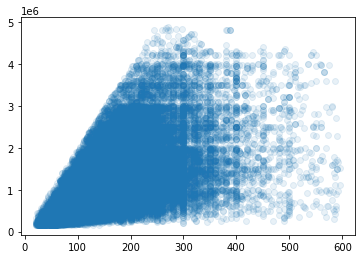

In [7]:
X = csv_data['AreaLiving'].to_numpy().reshape(-1, 1)
y = csv_data['PurchasePrice']
plt.scatter(X, y, alpha = 0.1)
plt.show()

# Linear Regression

In [8]:
csv_data_selected = csv_data[['PurchasePrice', 'AreaLiving']]
prepro = preprocessor(csv_data_selected, y_var='PurchasePrice')
prepro.preprocess()

Columns dropped to create X:  []


In [9]:
# prepro.encode_sample(csv_data_selected.drop(columns=['PurchasePrice']))

## Simple Linear Regression based on "AreaLiving"

In [10]:
reg = sklearn.linear_model.LinearRegression().fit(prepro.X_train, prepro.y_train)
print("R2-Score: {}. MAPE: {}".format(reg.score(prepro.X_test, prepro.y_test), mean_absolute_percentage_error(reg.predict(prepro.X_test), prepro.y_test)))

R2-Score: 0.3883113621297284. MAPE: 0.37194397165503795


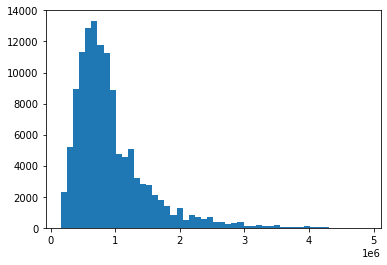

In [11]:
plt.hist(prepro.y_train, bins = 50)
plt.show()

## Residual Analysis

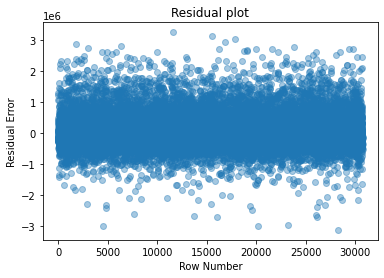

In [12]:
y_hat = reg.predict(prepro.X_test)
residuen = prepro.y_test - y_hat
plt.scatter(np.arange(len(residuen)), np.array(residuen), alpha = 0.4)
plt.title("Residual plot")
plt.xlabel("Row Number")
plt.ylabel("Residual Error")
plt.show()

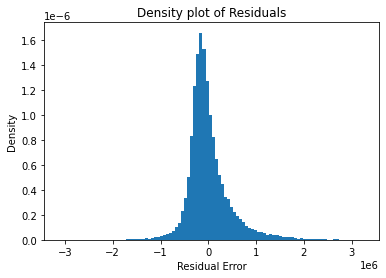

In [13]:
plt.hist(residuen, bins = 100, density = True, histtype = 'stepfilled')
plt.title("Density plot of Residuals")
plt.xlabel("Residual Error")
plt.ylabel("Density")
plt.show()

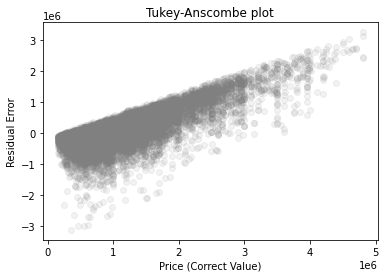

In [14]:
plt.scatter(prepro.y_test, np.array(residuen), alpha = 0.1, color = 'grey')
plt.title("Tukey-Anscombe plot")
plt.xlabel("Price (Correct Value)")
plt.ylabel("Residual Error")
plt.show()

In [15]:
 durbin_watson(residuen, prepro.y_test)

0.7477811806797575

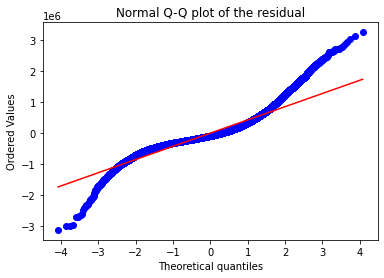

In [16]:
stats.probplot(residuen, dist="norm", plot=plt)
plt.title("Normal Q-Q plot of the residual")
plt.show()

Man kann anhand Durbin Watson sehen, dass es eine positive Autokorrelation hat, das also die Varianz zunimmt mit "Area Living". 
Der QQ-Plot zeigt auch ganz deutlich, dass die Residuen nicht normalverteilt sind. Dies sehen wir auch im Tukey-Anscombe Plot.
Wir können mit einem Linearen Modell also nicht die Varianz komplett erklären. Wir versuchen also nun mehr Varianz mit 
zusätzlichen Attributen zu erklären und die Verteilung von y, also dem Kaufpreis, anzupassen in dem wir den Logarithmus vom Preis ziehen.

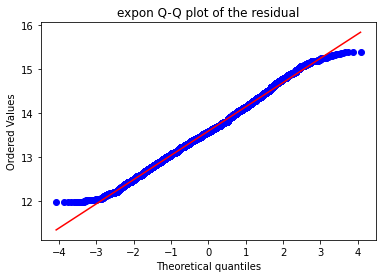

In [17]:
stats.probplot(np.log(prepro.y_test), dist="norm", plot=plt)
plt.title("expon Q-Q plot of the residual")
plt.show()

In [18]:
reg = sklearn.linear_model.LinearRegression().fit(prepro.X_train, np.log(prepro.y_train))
pred = np.exp(reg.predict(prepro.X_test))
print("R2-Score: {}. MAPE: {}".format(sklearn.metrics.r2_score(pred, prepro.y_test), mean_absolute_percentage_error(pred, prepro.y_test)))

R2-Score: -0.20089749298170667. MAPE: 0.3555584880825077


Eine grosse Verbesserung! Nun mit allen Attributen:

In [19]:
csv_data_zip_price_transformed = csv_data.copy()
csv_data_zip_price_transformed['Zip'] = (csv_data_zip_price_transformed['Zip']/100).astype('int8')
prepro = preprocessor(csv_data_zip_price_transformed, y_var='PurchasePrice', cols_to_drop=['StreetAndNr', 'LastUpdate', 'Locality', 'Id'],
                    numbers_to_encode=['Zip'])
prepro.preprocess()

Columns dropped to create X:  ['StreetAndNr', 'LastUpdate', 'Locality', 'Id']
Succesfully casted Dtypes!
 AreaLiving              float64
AreaProperty            float64
BuiltYear                 int64
FloorNumber             float64
ForestDensityL          float64
                         ...   
gde_workers_sector2     float64
gde_workers_sector3     float64
gde_workers_total       float64
location_has_street       int64
location_is_complete      int64
Length: 64, dtype: object


In [20]:
reg = sklearn.linear_model.LinearRegression()
reg.fit(prepro.X_train, np.log(prepro.y_train))
pred = np.exp(reg.predict(prepro.X_test))
print("R2-Score: {}. MAPE: {}".format(sklearn.metrics.r2_score(pred, prepro.y_test), mean_absolute_percentage_error(pred, prepro.y_test)))

R2-Score: 0.5034485947727472. MAPE: 0.23255715594789989


### Feature Selection mit Hilfe von EDA
Im Eda-Teil haben wir gesehen, dass nur wenige Features überhaupt positiv oder negativ Korrelieren mit dem Preis. 
Dies bedeutet, wir sollten ein ähnlich gutes Model mit nur wenigen Features herstellen können. Ebenfalls benutzen wir die Attribute,
von denen wir die Korrelation nicht berechnen können, also die "Onehot-Encoded"-Attribute.

In [21]:
### Params
min_abs_corr = 0.2
###
csv_data_corr = csv_data.corr()
csv_data_corr_filtered = csv_data_corr[np.abs(csv_data_corr)>min_abs_corr]['PurchasePrice']
list_attributes_affecting_price = csv_data_corr_filtered.dropna().index.to_list()
print("{} Attributes affecting Price.".format(len(list_attributes_affecting_price)))
print(*list_attributes_affecting_price)

8 Attributes affecting Price.
AreaLiving AreaProperty Rooms TravelTimeMiv gde_area_settlement_percentage gde_politics_fdp gde_pop_per_km2 PurchasePrice


In [22]:
list_attributes_affecting_price

['AreaLiving',
 'AreaProperty',
 'Rooms',
 'TravelTimeMiv',
 'gde_area_settlement_percentage',
 'gde_politics_fdp',
 'gde_pop_per_km2',
 'PurchasePrice']

In [23]:
list_attributes_affecting_price.extend(['GroupNameDe'])
csv_data_filtered = csv_data[list_attributes_affecting_price]
csv_data_filtered.head()

,AreaLiving,AreaProperty,Rooms,TravelTimeMiv,gde_area_settlement_percentage,gde_politics_fdp,gde_pop_per_km2,PurchasePrice,GroupNameDe
0,140.0,501.0,4.5,0.250000,18.431373,20.910840,619.019608,745000.0,Haus
1,143.0,277.0,5.5,0.250000,45.590994,15.196187,1487.030075,780000.0,Haus
2,160.0,712.0,7.0,0.333333,7.163969,22.931847,97.240991,570000.0,Haus
3,351.0,496.0,5.5,0.250000,4.934211,32.645301,114.052288,920000.0,Haus
4,400.0,1800.0,8.0,0.083333,70.461538,41.199149,1170.987654,3950000.0,Haus


In [24]:
prepro_filtered = preprocessor(csv_data_filtered, y_var='PurchasePrice', cols_to_drop=[], numbers_to_encode=[])#, 'Id'])
prepro_filtered.preprocess()

Columns dropped to create X:  []


In [25]:
reg = sklearn.linear_model.LinearRegression()
reg.fit(prepro_filtered.X_train, np.log(prepro_filtered.y_train))
pred = np.exp(reg.predict(prepro_filtered.X_test))
print("R2-Score: {}. MAPE: {}".format(sklearn.metrics.r2_score(prepro_filtered.y_test, pred), mean_absolute_percentage_error(pred, prepro_filtered.y_test)))

R2-Score: 0.24212374277694027. MAPE: 0.3162195390855383


Nicht sehr gut. Was passiert, wenn wir noch Zip (gerundet, siehe in EDA) onehot-encoded hinzufügen?

In [26]:
list_attributes_affecting_price.extend(['Zip'])
csv_data_filtered = csv_data[list_attributes_affecting_price]
csv_data_filtered['Zip'] = (csv_data_filtered['Zip']/100).astype('int8')
prepro_filtered = preprocessor(csv_data_filtered, y_var='PurchasePrice', cols_to_drop=[], numbers_to_encode=['Zip'])#, 'Id'])
prepro_filtered.preprocess()

Columns dropped to create X:  []
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
Succesfully casted Dtypes!
 AreaLiving                        float64
AreaProperty                      float64
Rooms                             float64
TravelTimeMiv                     float64
gde_area_settlement_percentage    float64
gde_politics_fdp                  float64
gde_pop_per_km2                   float64
GroupNameDe                        object
Zip                                object
dtype: object


In [27]:
reg = sklearn.linear_model.LinearRegression()
reg.fit(prepro_filtered.X_train, np.log(prepro_filtered.y_train))
pred = np.exp(reg.predict(prepro_filtered.X_test))
print("R2-Score: {}. MAPE: {}".format(sklearn.metrics.r2_score(pred, prepro_filtered.y_test), mean_absolute_percentage_error(pred, prepro_filtered.y_test)))

R2-Score: 0.36685458994377806. MAPE: 0.27467540558016373


MAPE hat sich um ca. 0.04 verbessert!

In [28]:
 # Instantiation 
xgb_r = xg.XGBRegressor(seed = 42)
# Fitting the model 
xgb_r.fit(prepro_filtered.X_train.values, np.log(prepro_filtered.y_train.values))
# Predict the model 
pred = np.exp(xgb_r.predict(prepro_filtered.X_test.values))
# Workaround because of dtype issue, so it's not possible to pass a dataframe. This is a workaround to still get column-names to use
# feature importance.y
xgb_r.get_booster().feature_names = prepro_filtered.X_train.columns.to_list()

In [29]:
print("R2-Score: {}. MAPE: {}".format(sklearn.metrics.r2_score(pred, prepro_filtered.y_test), mean_absolute_percentage_error(pred, prepro_filtered.y_test)))

R2-Score: 0.6558253742438165. MAPE: 0.19938006797105978


Eine starke Verbesserung! Ohne irgendwelche Parameteroptimierungen. Im nächsten Schritt sehen wir die Wichtigkeit der Attribute.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

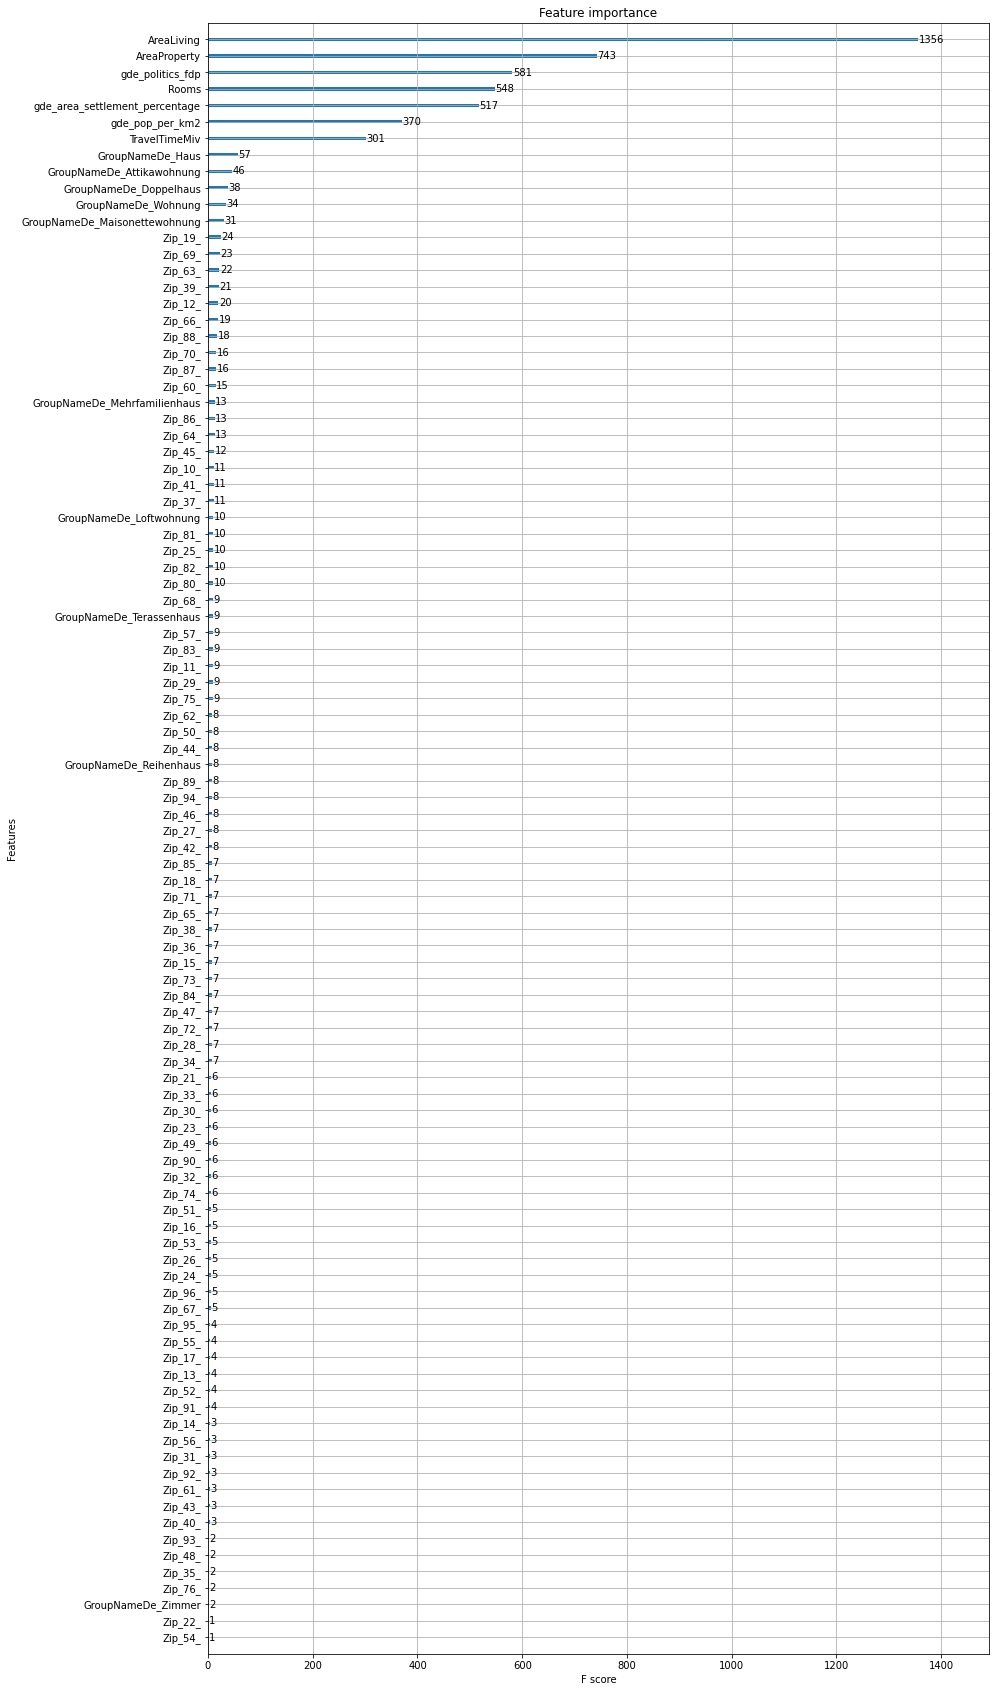

In [30]:
# plot
plt.rcParams["figure.figsize"] = (14, 30)
plot_importance(xgb_r)

Das Ergebniss ist schonmal ganz OK. Da es aber Boosted Random Forest Tree ist, müssen wir die Features nicht zwangsweise Onehot-Encoden. 
Wir können Objekte auch einfach Label-Encoden und somit Ram einsparen.

In [31]:
prepro = preprocessor(csv_data, y_var='PurchasePrice', method_to_encode='label_encode', cols_to_drop=['Id', 'LastUpdate', 'Locality', 'StreetAndNr'], numbers_to_encode=[])#, 'Id'])
prepro.preprocess()

Columns dropped to create X:  ['Id', 'LastUpdate', 'Locality', 'StreetAndNr']
/work/helper_functions/preprocessing.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obj[col] = self.labler.transform(df_obj[col])


In [32]:
 # Instantiation 
xgb_r = xg.XGBRegressor(seed = 42)
# Fitting the model 
xgb_r.fit(prepro.X_train.values, np.log(prepro.y_train.values))
# Predict the model 
pred = np.exp(xgb_r.predict(prepro.X_test.values))
# Workaround because of dtype issue, so it's not possible to pass a dataframe. This is a workaround to still get column-names to use
# feature importance.y
xgb_r.get_booster().feature_names = prepro.X_train.columns.to_list()

In [33]:
print("R2-Score: {}. MAPE: {}".format(sklearn.metrics.r2_score(pred, prepro_filtered.y_test), mean_absolute_percentage_error(pred, prepro_filtered.y_test)))

R2-Score: 0.7800784926370762. MAPE: 0.15908724349825099


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

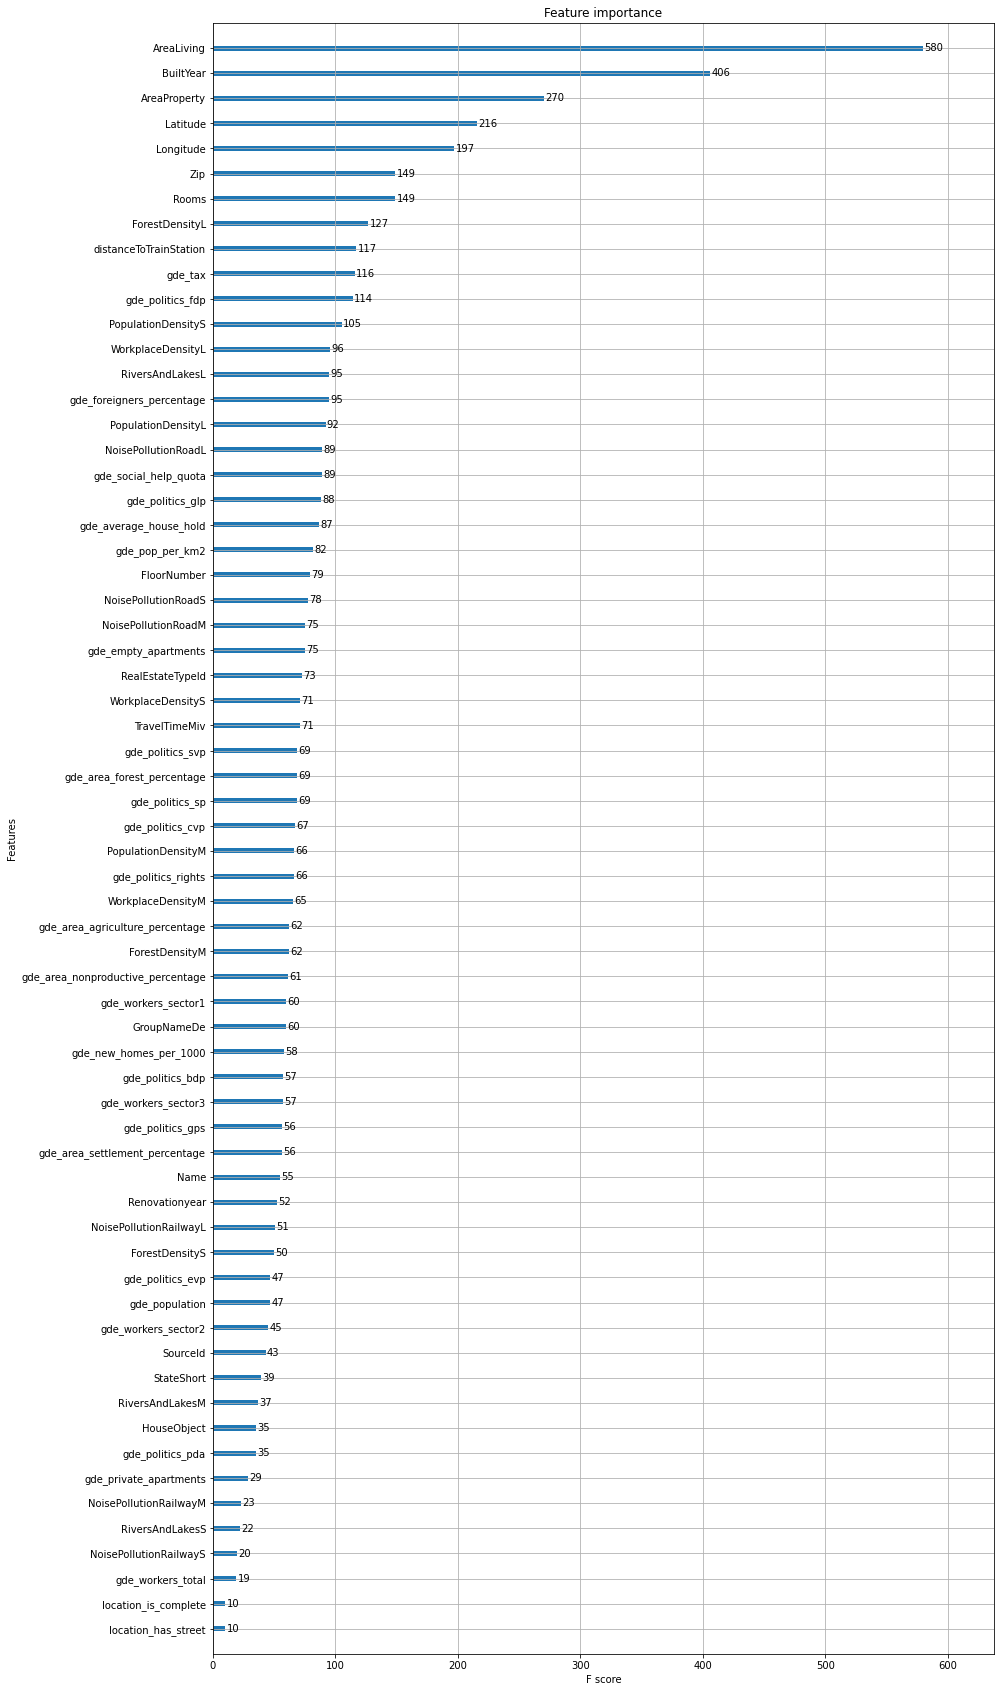

In [34]:
# plot
plt.rcParams["figure.figsize"] = (14, 30)
plot_importance(xgb_r)

Sieht schon gut aus! Nun bisschen Parameter-Tuning mit CV.

In [35]:
xgb = xg.XGBRegressor()
parameters =   {'learning_rate': [.03, .05], 
                'max_depth': [10],
                #'min_child_weight': [1, 3, 5],
                #'subsample': [0.5, 0.7],
                #'colsample_bytree': [0.5, 0.7],
                'n_estimators' : [900, 1000, 1100]
               }

xgb_grid = GridSearchCV(estimator = xgb,
                        param_grid  = parameters,
                        cv = 2,
                        n_jobs = -1,
                        verbose=2)


In [36]:
prepro = preprocessor(csv_data, y_var='PurchasePrice', method_to_encode='label_encode', cols_to_drop=['Id', 'LastUpdate', 'Locality', 'StreetAndNr'], numbers_to_encode=[], test_frac= 0.1)#, 'Id'])
prepro.preprocess()

Columns dropped to create X:  ['Id', 'LastUpdate', 'Locality', 'StreetAndNr']
/work/helper_functions/preprocessing.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obj[col] = self.labler.transform(df_obj[col])


In [37]:
#xgb_grid.fit(prepro.X_train.values, np.log(prepro.y_train.values))

In [38]:
pd.DataFrame(xgb_grid.cv_results_)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
xgb_grid.best_score_

In [ ]:
xgb_grid.best_params_

In [ ]:
pred = np.exp(xgb_grid.best_estimator_.predict(prepro.X_test.values))
print("R2-Score: {}. MAPE: {}".format(sklearn.metrics.r2_score(pred, prepro.y_test), mean_absolute_percentage_error(pred, prepro.y_test)))

In [ ]:
test_df = pd.read_csv('test.csv')
submission = test_df['Id']
test_df_prepro = prepro.encode_sample(test_df, test_data=True)
submission['Expected'] = np.exp(xgb_grid.best_estimator_.predict(test_df_prepro))
submission.to_csv('submission.csv', index=False)

In [ ]:
best_xgb = xg.XGBRegressor(params = {'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 900})
best_xgb.fit(prepro.X_train.values, np.log(prepro.y_train.values))

In [ ]:
test_df['HouseObject'].astype('bool')

In [ ]:
test_df_prepro['HouseObject']

In [ ]:
best_xgb.predictt(est_df_prepro.values)

In [ ]:
test_df

In [ ]:
test_df = pd.read_csv('test.csv')
test_df['HouseObject'] = test_df['HouseObject'].astype('bool')
submission = pd.DataFrame(columns=['Expected'], index = test_df['Id'])
test_df_prepro = prepro.encode_sample(test_df, test_data=True)

submission['Expected'] = np.exp(best_xgb.predict(test_df_prepro.values).reshape(-1, 1))
submission.to_csv('submission.csv',header=True)

In [ ]:
submission

In [ ]:
sub = pd.DataFrame(submission)
sub.columns = ['Expected']
sub['Id'] = sub.index
sub.to_csv('sub.csv', index = False, header = True)

In [ ]:
test_df_prepro['HouseObject']

In [ ]:
test_df_prepro